<a href="https://colab.research.google.com/github/kittisaktaoma/colab_practice/blob/master/CalcSynergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library 



In [ ]:
! wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
! chmod +x Miniconda3-latest-Linux-x86_64.sh
! ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
! conda config --set always_yes yes --set changeps1 no
! conda install -q -y -c conda-forge python=3.7
! conda install -q -y -c conda-forge rdkit==2020.09.2 

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem

In [ ]:
! pip install keras
! pip install tensorflow
! pip install keras-gcn
! pip install numpy
! pip install matplotlib
! pip install scipy
! pip install deepchem
! pip install keras-tuner
! pip install pubchempy
! pip install chembl_webresource_client

In [ ]:
import deepchem as dc
import tensorflow as tf
import tensorflow.keras.layers as layers
import pandas as pd
import numpy as np
import deepchem as dc
from rdkit import Chem
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import BayesianOptimization
from chembl_webresource_client.new_client import new_client
import tensorflow as tf
from tensorflow.keras.backend import variable, dot as k_dot, sigmoid, relu
from tensorflow.keras.layers import Dense, Input, Concatenate, Layer
import numpy as np
import urllib
import pubchempy as pcp
import random 


In [ ]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.pooling import MaxPooling1D
from keras.layers.merge import concatenate
from keras.preprocessing.sequence import pad_sequences

#Toy data

In [ ]:
sample_01 = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/sample.txt",sep="\t").iloc[:,1]
sample_02 = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/sample.txt",sep="\t").iloc[:,2]
all_sample = sample_01.append(sample_02).unique()
all_sample

array(['5-FU', 'ABT-888', 'AZD1775', 'BEZ-235', 'BORTEZOMIB',
       'CARBOPLATIN', 'CYCLOPHOSPHAMIDE', 'DASATINIB', 'DEXAMETHASONE',
       'DINACICLIB', 'DOXORUBICIN', 'ERLOTINIB', 'ETOPOSIDE',
       'GELDANAMYCIN', 'GEMCITABINE', 'L778123', 'LAPATINIB', 'METFORMIN',
       'METHOTREXATE', 'MITOMYCINE', 'MK-2206', 'MK-4541', 'MK-4827',
       'MK-5108', 'MK-8669', 'MRK-003', 'OXALIPLATIN', 'PACLITAXEL',
       'PD325901', 'SN-38', 'SORAFENIB', 'SUNITINIB', 'TEMOZOLOMIDE',
       'TOPOTECAN', 'VINBLASTINE', 'VINORELBINE', 'ZOLINZA',
       'CHEMBL17639', 'BUSULFAN', 'AZACYTIDINE', 'FLUDARABINE BASE',
       'TENIPOSIDE', 'NSC733504', 'EXEMESTANE', 'BLEOMYCIN',
       'ANTIBIOTIC AD 32', 'MITOXANTRONE', "5-FLUORO-2'-DEOXYURIDINE",
       'MITOTANE', 'METHOXSALEN', 'FULVESTRANT', 'CARMUSTINE',
       'ADM HYDROCHLORIDE', 'TAMOXIFEN CITRATE', 'CHEMBL277800',
       'ALLOPURINOL', 'THIOTEPA', 'MERCAPTOPURINE', 'ANTIBIOTIC AY 22989',
       'IFOSFAMIDE', 'ANASTROZOLE', 'VINCRISTINE SULFAT

#Drug structure


In [ ]:
drug_smiles = {}
for i in all_sample:
  try:
    print(i)
    res = pcp.get_compounds(i, 'name')
    SM = res[0].canonical_smiles   
    drug_smiles[i] = SM
  except Exception:
    pass

5-FU
ABT-888
AZD1775
BEZ-235
BORTEZOMIB


In [ ]:
list(drug_smiles.keys()).__len__()

124

In [ ]:
tmp_list = []
feat_mat = {}

curated_df = pd.DataFrame(drug_smiles.items(), columns=['Name', 'smiles'])

for i in range(curated_df.shape[0]):

  """
  create normalize adjacency matrix
  """

  mol = Chem.MolFromSmiles(curated_df.iloc[i,1])
  A = Chem.GetAdjacencyMatrix(mol).tolist()
  I = np.eye(A.__len__())

  A_hat = np.array(A + I)

  """
  create feaature matrix
  """

  f1 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetIsAromatic() for j in range(mol.GetNumAtoms())]]).T
  f2 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetNumRadicalElectrons() for j in range(mol.GetNumAtoms())]]).T
  X = np.array(pd.concat([f1,f2],axis=1)).astype(int)

  """
  multiplication A_hat*X
  """

  tmp_res = A_hat @ X

  """
  Padding matrix
  """

  tmp_list.append(tmp_res)

  if i == (curated_df.shape[0]-1):
      max_atom_number = max([tmp_list[i].__len__() for i in range(curated_df.shape[0])])
      tmp_pad = pad_sequences(tmp_list, padding='post',maxlen=max_atom_number)
      
      for j in range(curated_df.shape[0]):
        feat_mat[curated_df.iloc[j,0]] = tmp_pad[j]

In [ ]:
feat_mat.__len__()

124

#Target protein

In [ ]:
target_protein = {}
for i in all_sample:
  try:
    print(i)
    c = pcp.get_compounds(i, 'name')
    pubmed_query_length = str(c[0].cid).__len__()
    add_length = 8 - int(pubmed_query_length)
    stitch_cid = "CIDs"+ '0'*int(add_length) + str(c[0].cid)
    target_prot = np.array(pd.read_csv("http://stitch.embl.de/api/tsv/interactors?identifier="+stitch_cid+"&species=9606",sep="\t").iloc[1:,:])
    target_protein[i] = target_prot
  except Exception:
    pass


In [ ]:
target_protein

{'1-(5-DEOXYPENTOFURANOSYL)-5-FLUORO-4-{[(PENTYLOXY)CARBONYL]AMINO}PYRIMIDIN-2(1H)-ONE': array([], shape=(0, 1), dtype=object),
 '34793-34-5': array([], shape=(0, 1), dtype=object),
 "5-FLUORO-2'-DEOXYURIDINE": array([['9606.ENSP00000315644'],
        ['9606.ENSP00000252029'],
        ['9606.ENSP00000301634'],
        ['9606.ENSP00000462196'],
        ['9606.ENSP00000370376'],
        ['9606.ENSP00000306390'],
        ['9606.ENSP00000233146'],
        ['9606.ENSP00000242576'],
        ['9606.ENSP00000231790'],
        ['9606.ENSP00000388648']], dtype=object),
 '5-FU': array([['9606.ENSP00000359211'],
        ['9606.ENSP00000315644'],
        ['9606.ENSP00000330032'],
        ['9606.ENSP00000252029'],
        ['9606.ENSP00000269305'],
        ['9606.ENSP00000311032'],
        ['9606.ENSP00000301141'],
        ['9606.ENSP00000387230'],
        ['9606.ENSP00000275493'],
        ['9606.ENSP00000276927']], dtype=object),
 'ABIRATERONE': array([['9606.ENSP00000358903'],
        ['9606.ENSP00

In [ ]:
list(target_protein.values())[0].tolist()

[['9606.ENSP00000359211'],
 ['9606.ENSP00000315644'],
 ['9606.ENSP00000330032'],
 ['9606.ENSP00000252029'],
 ['9606.ENSP00000269305'],
 ['9606.ENSP00000311032'],
 ['9606.ENSP00000301141'],
 ['9606.ENSP00000387230'],
 ['9606.ENSP00000275493'],
 ['9606.ENSP00000276927']]

#protein ID conversion

In [ ]:
test = [list(target_protein.values())[i].tolist() for i in range(len(target_protein))]
test_01 = sum(sum(test, []),[])
final = [s.replace('9606.',"") for s in test_01]
len(final)

945

In [ ]:
#! pip install stringdb
import stringdb
string_ids = stringdb.get_string_ids(final)
enrichment_df = stringdb.get_enrichment(string_ids.queryItem)
enrichment_df

,category,term,number_of_genes,number_of_genes_in_background,ncbiTaxonId,inputGenes,preferredNames,p_value,fdr,description
0,Process,GO:0050896,399,7824,9606,"ENSP00000001008,ENSP00000001146,ENSP0000001380...","FKBP4,CYP26B1,ERCC1,MYOC,MAPK1,HMOX1,FKBP3,APE...",1.320000e-80,9.400000e-77,response to stimulus
1,Process,GO:0070887,244,2672,9606,"ENSP00000001008,ENSP00000001146,ENSP0000021583...","FKBP4,CYP26B1,MAPK1,HMOX1,APEX1,GSR,TGFB1,HGF,...",4.750000e-80,1.690000e-76,cellular response to chemical stimulus
2,Process,GO:0042221,296,4153,9606,"ENSP00000001008,ENSP00000001146,ENSP0000001380...","FKBP4,CYP26B1,ERCC1,MAPK1,HMOX1,APEX1,AHCY,GSR...",2.800000e-78,6.660000e-75,response to chemical
3,Process,GO:0051716,352,6212,9606,"ENSP00000001008,ENSP00000001146,ENSP0000001380...","FKBP4,CYP26B1,ERCC1,MYOC,MAPK1,HMOX1,FKBP3,APE...",1.380000e-74,2.470000e-71,cellular response to stimulus
4,Process,GO:0010033,242,2815,9606,"ENSP00000001008,ENSP00000001146,ENSP0000001380...","FKBP4,CYP26B1,ERCC1,MAPK1,HMOX1,APEX1,TGFB1,HG...",3.970000e-74,5.660000e-71,response to organic substance
...,...,...,...,...,...,...,...,...,...,...
5030,NetworkNeighborAL,CL:21700,9,131,9606,"ENSP00000217426,ENSP00000219431,ENSP0000025503...","AHCY,MPG,CRP,GGH,DHFRL1,ALAS1,GGT1,GGT2,DHFR",6.900000e-03,3.850000e-02,"mixed, incl. alpha-amino acid metabolic proces..."
5031,NetworkNeighborAL,CL:13762,4,28,9606,"ENSP00000262193,ENSP00000270586,ENSP0000035532...","PSMB1,PSMB6,PSMB5,PSMB2",7.000000e-03,3.880000e-02,Proteasome
5032,NetworkNeighborAL,CL:19893,11,181,9606,"ENSP00000216911,ENSP00000217133,ENSP0000024843...","AURKA,TUBB1,TUBA4A,TUBG1,PLK4,TUBA1A,TUBB,TUBB...",7.000000e-03,3.880000e-02,"mixed, incl. Recruitment of NuMA to mitotic ce..."
5033,NetworkNeighborAL,CL:989,7,86,9606,"ENSP00000264144,ENSP00000264187,ENSP0000034667...","LAMC2,NID1,FYN,ITGAL,DMD,SRC,YES1",7.200000e-03,3.930000e-02,"mixed, incl. ECM-receptor interaction, and cel..."


In [ ]:
PI3K_gene = enrichment_df[enrichment_df.category == "KEGG"]
PI3K_gene

,category,term,number_of_genes,number_of_genes_in_background,ncbiTaxonId,inputGenes,preferredNames,p_value,fdr,description
3533,KEGG,hsa05200,129,515,9606,"ENSP00000211122,ENSP00000215832,ENSP0000021611...","GSTA3,MAPK1,HMOX1,TGFB1,HGF,RPS6KB1,IL2,CCND1,...",7.780000e-83,2.100000e-80,Pathways in cancer
3534,KEGG,hsa04151,83,348,9606,"ENSP00000215832,ENSP00000222390,ENSP0000022547...","MAPK1,HGF,CSF3,RPS6KB1,IL2,CCND1,IL4,FLT3,RAF1...",7.320000e-51,9.880000e-49,PI3K-Akt signaling pathway
3535,KEGG,hsa01521,43,78,9606,"ENSP00000215832,ENSP00000222390,ENSP0000022557...","MAPK1,HGF,RPS6KB1,RAF1,KRAS,PDGFRA,PDGFRB,MAPK...",8.680000e-39,7.810000e-37,EGFR tyrosine kinase inhibitor resistance
3536,KEGG,hsa05206,50,149,9606,"ENSP00000215832,ENSP00000216117,ENSP0000022750...","MAPK1,HMOX1,CCND1,RAF1,KRAS,PDGFRA,MDM2,THBS1,...",1.310000e-36,8.850000e-35,MicroRNAs in cancer
3537,KEGG,hsa05205,52,195,9606,"ENSP00000215832,ENSP00000221930,ENSP0000022239...","MAPK1,TGFB1,HGF,RPS6KB1,CCND1,SMO,RAF1,KRAS,MD...",6.780000e-34,3.660000e-32,Proteoglycans in cancer
...,...,...,...,...,...,...,...,...,...,...
3722,KEGG,hsa00592,3,25,9606,"ENSP00000312286,ENSP00000333142,ENSP00000356436","PLA2G1B,PLA2G6,PLA2G4A",2.910000e-02,4.140000e-02,alpha-Linolenic acid metabolism
3723,KEGG,hsa04714,11,228,9606,"ENSP00000225577,ENSP00000244289,ENSP0000025607...","RPS6KB1,LIPE,KRAS,PPARG,RPTOR,MTOR,NRAS,PRKAA2...",3.080000e-02,4.350000e-02,Thermogenesis
3724,KEGG,hsa00130,2,10,9606,"ENSP00000319788,ENSP00000348234","NQO1,TAT",3.260000e-02,4.570000e-02,Ubiquinone and other terpenoid-quinone biosynt...
3725,KEGG,hsa04713,6,93,9606,"ENSP00000215832,ENSP00000254657,ENSP0000026302...","MAPK1,PER2,MAPK3,FOS,CREB1,PRKCA",3.250000e-02,4.570000e-02,Circadian entrainment


In [ ]:
PI3K_gene_list = PI3K_gene.iloc[1,5].split(",")
PI3K_gene_list_02 = ["9606."+i for i in PI3K_gene_list]
PI3K_gene_list_02

['9606.ENSP00000215832',
 '9606.ENSP00000222390',
 '9606.ENSP00000225474',
 '9606.ENSP00000225577',
 '9606.ENSP00000226730',
 '9606.ENSP00000227507',
 '9606.ENSP00000231449',
 '9606.ENSP00000241453',
 '9606.ENSP00000251849',
 '9606.ENSP00000252723',
 '9606.ENSP00000256078',
 '9606.ENSP00000257290',
 '9606.ENSP00000257904',
 '9606.ENSP00000417281',
 '9606.ENSP00000260356',
 '9606.ENSP00000286301',
 '9606.ENSP00000261937',
 '9606.ENSP00000263025',
 '9606.ENSP00000263826',
 '9606.ENSP00000263923',
 '9606.ENSP00000263967',
 '9606.ENSP00000264144',
 '9606.ENSP00000264498',
 '9606.ENSP00000265171',
 '9606.ENSP00000266970',
 '9606.ENSP00000267101',
 '9606.ENSP00000267843',
 '9606.ENSP00000268035',
 '9606.ENSP00000269305',
 '9606.ENSP00000269571',
 '9606.ENSP00000270139',
 '9606.ENSP00000275493',
 '9606.ENSP00000276927',
 '9606.ENSP00000282397',
 '9606.ENSP00000288135',
 '9606.ENSP00000297494',
 '9606.ENSP00000299767',
 '9606.ENSP00000302150',
 '9606.ENSP00000302486',
 '9606.ENSP00000302564',


In [ ]:
tmp_dict = {}

for i in range(len(target_protein)):
  query_list = set(sum(list(target_protein.values())[i].tolist(),[]))
  ref_list = set(PI3K_gene_list_02)
  res_list = list(query_list & ref_list)
  tmp_dict[list(target_protein.keys())[i]] = res_list


In [ ]:
res_tmp = pd.DataFrame(tmp_dict.items())


,0,1
0,5-FU,"[9606.ENSP00000276927, 9606.ENSP00000269305, 9..."
1,ABT-888,"[9606.ENSP00000418960, 9606.ENSP00000275493]"
2,AZD1775,[]
3,BEZ-235,"[9606.ENSP00000263967, 9606.ENSP00000354558, 9..."
4,BORTEZOMIB,"[9606.ENSP00000269305, 9606.ENSP00000376943]"
...,...,...
117,RUXOLITINIB,"[9606.ENSP00000343204, 9606.ENSP00000371067, 9..."
118,VANDETANIB,"[9606.ENSP00000263923, 9606.ENSP00000275493, 9..."
119,NSC707389,[]
120,NSC256439,[]


#Boolean

In [98]:
# Some code to return a Pandas dataframe, given tabular text

def to_df(result):
    return pd.read_table(io.StringIO(result), header=None)

#! pip install Bio
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
import pandas as pd
import io

result = REST.kegg_link("hsa", "hsa04151").read()
to_df(result)


,0,1
0,path:hsa04151,hsa:10000
1,path:hsa04151,hsa:10018
2,path:hsa04151,hsa:100533105
3,path:hsa04151,hsa:10110
4,path:hsa04151,hsa:10161
...,...,...
349,path:hsa04151,hsa:9470
350,path:hsa04151,hsa:9586
351,path:hsa04151,hsa:9623
352,path:hsa04151,hsa:9863


In [193]:
from IPython.display import Image
from Bio.KEGG.KGML.KGML_parser import read
s = REST.kegg_get("hsa04151","kgml").read()
print(read(s).relations[0])

Relation (subtypes: 2):
Entry1:
Entry node ID: 18
Names: hsa:5170
Type: gene
Components: set()
Reactions: 
Graphics elements: 1 [<Bio.KEGG.KGML.KGML_pathway.Graphics object at 0x7f8486bbc4a8>]

Entry2:
Entry node ID: 232
Names: hsa:100533105 hsa:10110 hsa:23678 hsa:6446
Type: gene
Components: set()
Reactions: 
Graphics elements: 1 [<Bio.KEGG.KGML.KGML_pathway.Graphics object at 0x7f8486cb4ba8>]

Subtype: activation
-->
Subtype: phosphorylation
+p


In [189]:
node_1 = str(read(s).relations[0].entry1).split("\n")
#node_2 = read(s).relations[0].entry2
#action = read(s).relations[0].subtypes
#res = str(node_1) + str(node_2) + str(action)
str(read(s).relations[0]).split("\n")

['Relation (subtypes: 2):',
 'Entry1:',
 'Entry node ID: 17',
 'Names: hsa:10000 hsa:207 hsa:208',
 'Type: gene',
 'Components: set()',
 'Reactions: ',
 'Graphics elements: 1 [<Bio.KEGG.KGML.KGML_pathway.Graphics object at 0x7f8486725080>]',
 '',
 'Entry2:',
 'Entry node ID: 51',
 'Names: hsa:2309',
 'Type: gene',
 'Components: set()',
 'Reactions: ',
 'Graphics elements: 1 [<Bio.KEGG.KGML.KGML_pathway.Graphics object at 0x7f84867ca898>]',
 '',
 'Subtype: inhibition',
 '--|',
 'Subtype: phosphorylation',
 '+p']

In [30]:
print(res.genes)

[<Bio.KEGG.KGML.KGML_pathway.Entry object at 0x7f8490356358>, <Bio.KEGG.KGML.KGML_pathway.Entry object at 0x7f8490356128>, <Bio.KEGG.KGML.KGML_pathway.Entry object at 0x7f8490275cf8>, <Bio.KEGG.KGML.KGML_pathway.Entry object at 0x7f8490275d68>, <Bio.KEGG.KGML.KGML_pathway.Entry object at 0x7f8490275dd8>, <Bio.KEGG.KGML.KGML_pathway.Entry object at 0x7f849027e048>, <Bio.KEGG.KGML.KGML_pathway.Entry object at 0x7f849027e0b8>, <Bio.KEGG.KGML.KGML_pathway.Entry object at 0x7f849027e128>, <Bio.KEGG.KGML.KGML_pathway.Entry object at 0x7f849027e198>, <Bio.KEGG.KGML.KGML_pathway.Entry object at 0x7f849027e208>, <Bio.KEGG.KGML.KGML_pathway.Entry object at 0x7f849027e278>, <Bio.KEGG.KGML.KGML_pathway.Entry object at 0x7f849027e2e8>, <Bio.KEGG.KGML.KGML_pathway.Entry object at 0x7f849027e358>, <Bio.KEGG.KGML.KGML_pathway.Entry object at 0x7f849027e3c8>, <Bio.KEGG.KGML.KGML_pathway.Entry object at 0x7f849027e438>, <Bio.KEGG.KGML.KGML_pathway.Entry object at 0x7f849027e4a8>, <Bio.KEGG.KGML.KGML_pat

In [21]:
g.reactions

dict_values([])

#Cell line

#Model

In [ ]:
class GraphConv(Layer):
    
    """
    GraphConv require two inputs: padding feature and padding adjacency matrix of each drug

    """
    def __init__(self,output_dim,activation="sigmoid"):
        super().__init__()
        self.units = output_dim
        self.activation_function = activation

    def build(self, input_shape):
        
        """ 
        weight in GCN : 
        row is number of feature
        column is the number of output node

        """
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units), 
            initializer="random_normal",
            trainable=True)
        
    

    def call(self,inputs):
      """
      Inputs = padding feature matrix 
      A = padding adjacency matrix

      """
      if self.activation_function == 'relu':
        return relu(inputs @ self.w)
      else:
        return sigmoid(inputs @ self.w)


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 10, 30)]     0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 30, 2)]      0                                            
__________________________________________________________________________________________________
graph_conv_19 (GraphConv)       (None, 10, 2)        60          input_15[0][0]                   
__________________________________________________________________________________________________
graph_conv_21 (GraphConv)       (None, 30, 2)        4           input_16[0][0]                   
____________________________________________________________________________________________

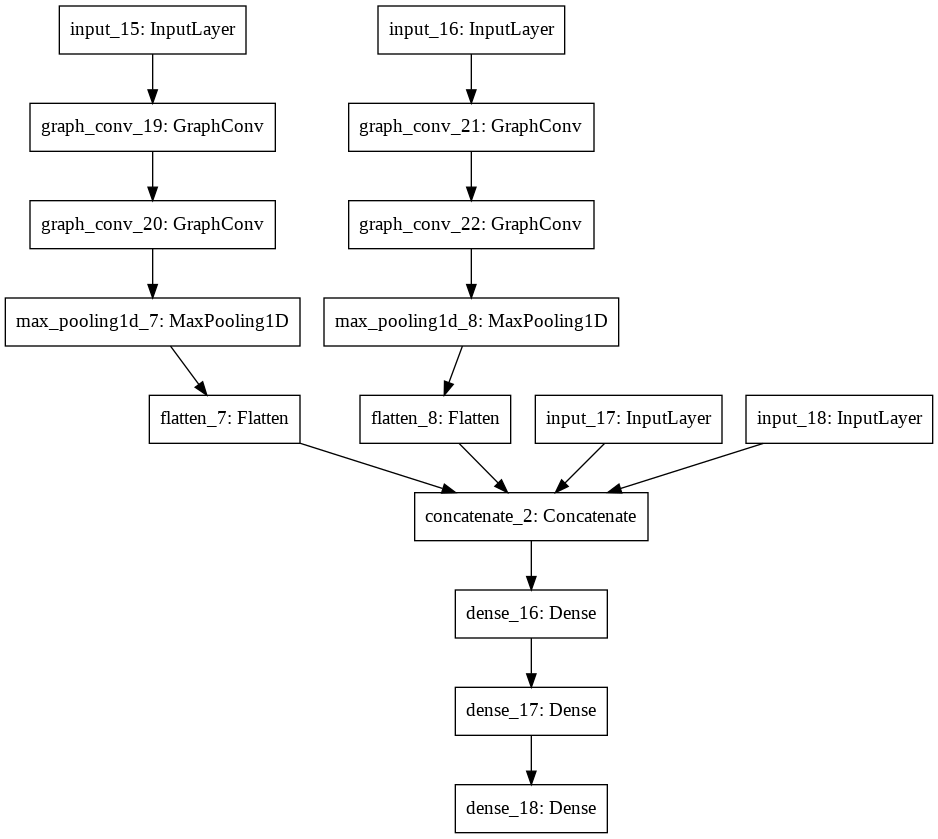

In [ ]:
# first input model

#boolean

visible1 = Input(shape=(10,30))
layer1 = GraphConv(2,activation='relu')(visible1)
layer2 = GraphConv(2,activation='relu')(layer1)
pool12 = tf.keras.layers.MaxPooling1D()(layer2)
flat1 = Flatten()(pool12)

#drug structure
visible2 = Input(shape=(30,2))
layer1 = GraphConv(2,activation='relu')(visible2)
layer2 = GraphConv(2,activation='relu')(layer1)
pool12 = tf.keras.layers.MaxPooling1D()(layer2)
flat2 = Flatten()(pool12)

#target protein
flat3 = Input(shape=(30,))

#cell line
flat4 = Input(shape=(30,))


# merge input models
merge = concatenate([flat1,flat2,flat3,flat4])
# interpretation model
hidden1 = Dense(2, activation='relu')(merge)
hidden2 = Dense(2, activation='relu')(hidden1)
output = Dense(1, activation='sigmoid')(hidden2)
model = Model(inputs=[visible1,visible2,flat3,flat4], outputs=output)
# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file='multilayer_perceptron_graph.png')

##Simulate data

In [ ]:
def tune_nn_model(hp):
    model = keras.Sequential()
    
    drop_rate = hp.Choice('drop_rate',
                            [
                              0.0,
                              0.1,
                              0.2,
                              0.3,
                              0.4,
                              0.5,
                              0.6,
                              0.7,
                              0.8,
                              0.9
                            ])

     
    model.add(keras.layers.Dense(
      units=28,
      activation="relu",
      input_shape=[df_x.shape[1]]
    ))
    model.add(keras.layers.Dropout(rate=drop_rate))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dropout(rate=drop_rate))
    model.add(keras.layers.Dense(1, activation='sigmoid')) 
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    momentum = hp.Choice('momentum', [0.0, 0.2, 0.4, 0.6, 0.8, 0.9])

    model.compile(
        optimizer=keras.optimizers.SGD(lr, momentum=momentum),
        loss = 'binary_crossentropy',
        metrics = ['accuracy'])
    return model

In [ ]:
b_tuner = BayesianOptimization(
    tune_nn_model,
    objective='accuracy',
    max_trials=20,
    executions_per_trial=5,
    directory='test_dir_03',
    project_name='b_tune_nn'
)

INFO:tensorflow:Reloading Oracle from existing project test_dir_03/b_tune_nn/oracle.json
